<a href="https://colab.research.google.com/github/Murcha1990/ML_AI25/blob/main/Hometasks/Base/HW2_Gradient_descent_base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Домашнее задание: Градиентный спуск — базовые концепции**


В этом домашнем задании вы попрактикуетесь в двух вещах:

1. **Градиентный спуск**
   Вы реализуете базовый GD, закрепите на практике его свойства и научитесь интерпретировать результаты.

2. **Дебаггинг**
   По ходу выполнения заданий вам потребуется выявлять и исправлять ошибки — в паре мест — в программной реализации.

##### **Почему дебаггинг?**

На практике, особенно часто при работе с обучением моделей придется читать ошибки и обеспечивать совместимость своего кода с написанным ранее. При этом, написанный ранее код может быть написан не идеально — не важно LLM его писала или человек.

В этом домашнем задании вы:

* реализуете класс GD с треккингом лосса и градиентов;
* проверите, корректно ли ваш оптимизатор работает на разных функциях (в том числе на не выпуклых!);
* потренируетесь читать графики loss;
* получите много красивых визуализаций;

**Ошибки только в функции для графиков!**

**Дедлайн: 13 декабря 23:59**



In [2]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler
import pandas as pd

np.random.seed(42)

In [ ]:
pio.renderers.default = "browser" #не выводились картинки под блоками кода, сделала, чтобы в браузере были 

### **Функция для картинок**

Эта функция для красивых графиков. Разберитесь в ее работе (можно - при помощи LLM).

<font color="red">В функции в двух местах преднамеренно допущены ошибки. Исправьте их. </font>

In [12]:
#сделано через LLM, разрешили выше
import numpy as np
import plotly.graph_objects as go


def plot_gd_3d(
    x_range, y_range, Z, loss_fn, history_dict,
    title="Градиентный спуск (3D)", min_point=None
):
    """
    3D-график функции + траектории градиентного спуска.

    x_range, y_range : 1D np.array
    Z : 2D np.array with shape (len(y_range), len(x_range))
    loss_fn : callable(params) -> float
    history_dict : dict[str, history]
        history["params"] — список точек (x, y)
    min_point : tuple (x*, y*) или None
    """

    fig = go.Figure()

    # --- Поверхность ---
    fig.add_trace(
        go.Surface(
            x=x_range,
            y=y_range,
            z=Z,
            opacity=0.7,
            showscale=False
        )
    )

    # --- Траектории ---
    for label, history in history_dict.items():
        trajectory = np.array(history.get("params", []))
        if len(trajectory) == 0:
            continue

        x_traj = trajectory[:, 0]
        y_traj = trajectory[:, 1]
        z_traj = np.array([loss_fn(p) for p in trajectory])   # ✔ исправлено

        fig.add_trace(
            go.Scatter3d(
                x=x_traj,
                y=y_traj,
                z=z_traj,
                mode='lines+markers',
                name=label,
                marker=dict(size=4),
                line=dict(width=4)
            )
        )

    # --- Минимум ---
    if min_point is not None:
        x_min, y_min = min_point
        fig.add_trace(
            go.Scatter3d(
                x=[x_min],
                y=[y_min],
                z=[loss_fn(np.array([x_min, y_min]))],
                mode='markers',
                name='Минимум',
                marker=dict(size=6, symbol='diamond-open')
            )
        )

    fig.update_layout(
        title=title,
        scene=dict(
            xaxis_title="x",
            yaxis_title="y",
            zaxis_title="f(x, y)"
        ),
        height=700
    )

    fig.show()



def plot_gd_2d(
    x_range, y_range, Z, history_dict,
    title="Градиентный спуск (2D контуры)",
    start_points=None, min_point=None, contour_kwargs=None
):
    """
    2D-контуры + траектории градиентного спуска.

    x_range, y_range : 1D np.array
    Z : 2D np.array
    history_dict : dict[str, history]
        history["params"] — список (x, y)
    start_points : list[np.array] или None
    min_point : tuple (x*, y*) или None
    contour_kwargs : dict или None
    """

    if contour_kwargs is None:
        contour_kwargs = dict(
            colorscale='Viridis',
            showscale=False,
            contours=dict(start=0, end=30, size=2),
            opacity=0.7,
        )

    fig = go.Figure()

    # --- Контурный график ---
    fig.add_trace(
        go.Contour(
            x=x_range,
            y=y_range,
            z=Z,
            **contour_kwargs
        )
    )

    # --- Траектории ---
    for label, history in history_dict.items():
        trajectory = np.array(history.get("params", []))
        if len(trajectory) == 0:
            continue

        fig.add_trace(
            go.Scatter(
                x=trajectory[:, 0],
                y=trajectory[:, 1],
                mode='lines+markers',
                name=label,
                marker=dict(size=5),
                line=dict(width=3)
            )
        )

    # --- Стартовые точки ---
    if start_points is not None:
        for i, p0 in enumerate(start_points):
            fig.add_trace(
                go.Scatter(
                    x=[p0[0]],
                    y=[p0[1]],              # ✔ исправлено
                    mode='markers',
                    name=f'Start {i+1}',
                    marker=dict(size=10, symbol='x')
                )
            )

    # --- Минимум ---
    if min_point is not None:
        x_min, y_min = min_point
        fig.add_trace(
            go.Scatter(
                x=[x_min],
                y=[y_min],
                mode='markers',
                name='Минимум',
                marker=dict(size=10, symbol='diamond-open')
            )
        )

    fig.update_layout(
        title=title,
        xaxis_title="x",
        yaxis_title="y",
        height=700
    )

    fig.show()

### **Задание 1. Градиентный спуск: постановка задачи (3 балла)**


Напомним, что в задачах машинного обучения мы хотим минимизировать **функцию потерь**
$$L(w): \mathbb{R}^d \to \mathbb{R},$$
где $w \in \mathbb{R}^d$ — вектор параметров модели (веса), а $L$ измеряет качество этой модели на данных. Пострейший пример функции потерь — MSE потери. Если мы обозначим за $y_i$ истинный прогноз, а за $\hat{y}$ — предсказанный моделью, то MSE — функция вида:

$$L(\hat{y}, y) = \frac{1}{n}\sum_{i=1}^{n} (y - \hat{y})^2$$

Если функция потерь дифференцируема, один из базовых численных методов для её минимизации — **градиентный спуск** (Gradient Descent). Если же функция потерь дифференцируема не везде — мы используем в "плохих точках" [субградиент](https://www.google.com/search?client=safari&rls=en&q=%D0%A1%D1%83%D0%B1%D0%B3%D1%80%D0%B0%D0%B4%D0%B8%D0%B5%D0%BD%D1%82&ie=UTF-8&oe=UTF-8).

#### **Идея метода градиетного спуска**

Градиент $\nabla L(w)$ по определению показывает направление **наискорейшего роста** функции. Чтобы уменьшать значение $L(w)$, нужно двигаться в противоположную сторону — туда, где функция убывает:

$$w_{k+1} = w_k - \eta \nabla L(w_k),$$

где

* $w_k$ — параметры на итерации $k$,
* $\eta > 0$ — шаг обучения (learning rate),
* $\nabla L(w_k)$ — градиент функции потерь по параметрам $w$ в точке $w_k$.

При достаточно «хороших» свойствах $L(w)$ (выпуклость — можно обозвать это "парабольным" поведением и гладкость — дифференцируемость везде) и правильно подобранном шаге $\eta$ последовательность ${w_k}$ будет стремиться к точке минимума. На практике, свойства функции мы проверяем не всегда, так как используем золотой набор функций устоявшийся в области и ключевую роль играет шаг $\eta$.

#### **Детали? Детали!**

При реализации градиентного спуска нужно учитывать:

1. **Инициализацию**

   Необходимо задать начальное значение параметров $w_0$.

2. **Шаг обучения $\eta$**

     Его правильный подбор — это искусство.

3. **Критерии остановки**

   Обычно метод выполняется фиксированное число итераций $N$, либо пока не выполнится одно из условий:

   * $|\nabla L(w_k)|$ стало достаточно малым;
   * изменение параметров $|w_{k+1} - w_k|$ мало;
   * изменение значения потерь $|L(w_{k+1}) - L(w_k)|$ мало.

4. **История обучения**

   Для анализа работы алгоритма полезно сохранять:

   * значения параметров $w_k$ на каждой итерации;
   * значения функции потерь $L(w_k)$;
   * (не обязательно, но полезно) значения нормы градиента $|\nabla L(w_k)|$.

    Эта информация позволит визуализировать траекторию спуска и поведение loss-функции во времени. Когда у нас есть этот график (да и вообще все 3 из перечисленных), мы можем понимать, как у обучения дела.


#### **1. Выпуклость и нет (1.5 балла)**

Из теории мы также знаем, что хочется минимизировать **выпуклые функции**. Почему именно их? Они приятные и у них:

* либо один глобальный минимум,
* либо целое выпуклое множество глобальных минимумов,
* нет локальных минимумов.

Это означает, что при разумном шаге градиентный спуск, стартуя из любой точки, будет стремиться к глобальному минимуму.

Формально, функция $f:\mathbb{R}^d \to \mathbb{R}$ называется **выпуклой**, если для любых $x, y \in \mathbb{R}^d$ и $\lambda \in [0, 1]$:
$$f(\lambda x + (1-\lambda) y) \leq \lambda f(x) + (1-\lambda) f(y)$$

Для дважды дифференцируемых функций это эквивалентно тому, что их **матрица Гессе** (матрица вторых производных) неотрицательно определена во всех точках.

Но это всё детали. Которые полезно знать. Но в реальных задачах машинного обучения мы почти всегда сталкиваемся с **невыпуклыми** функциями потерь.

Уметь понимать поведение на выпуклом и невыпуклом ландшафте по лоссу/градиенту важно, потому что это поможет вам в будущем изучать графики ваших моделей более четко и понимать, почему обучение застряло и что с этим можно сделать (добавить инерцию, перестартануть с других точек и так далее). Что же, давайте знакомиться с разным поведением!

#### **1. 1. Задание: реализуйте в коде функции и их градиенты**

1. **Простая квадратичная функция** (выпуклая):
   
   $f(x, y) = x^2 + y^2.$

2. **Функция Розенброка ([Rosenbrock's banana function](https://ru.wikipedia.org/wiki/%D0%A4%D1%83%D0%BD%D0%BA%D1%86%D0%B8%D1%8F_%D0%A0%D0%BE%D0%B7%D0%B5%D0%BD%D0%B1%D1%80%D0%BE%D0%BA%D0%B0))**:

   $f_{\text{R}}(x, y) = (a - x)^2 + b(y - x^2)^2$, тут по умолчанию a=1, b=100, но далее надо реализовывать a и b как гиперпараметры.

Мы будем использовать эти функции дальше для визуализации траекторий градиентного спуска, сравнения влияния шага обучения и анализа ландшафта.

**Ваши задачи в этом подпункте:**

1. Реализовать функции:

   * `quadratic_loss(params)`
   * `rosenbrock_loss(params, a=1, b=100)`

2. Реализовать их градиенты:

   * `quadratic_grad(params)` — возвращает `[grad_x, grad_y]`
   * `rosenbrock_grad(params, a=1, b=100)` — возвращает `[grad_x, grad_y]`


Дальше эти функции будут использоваться в классе `GradientDescent` для экспериментов с разными значениями шага обучения и для 2D/3D визуализаций ландшафта.



In [ ]:
# Квадратичная функция
def quadratic_loss(params):
    x, y = params
    return x**2 + y**2

def quadratic_grad(params):
    x, y = params
    return [2*x, 2*y]

# Функция Розенброка
def rosenbrock_loss(params, a=1, b=100):
    x, y = params
    return (a - x)**2 + b * (y - x**2)**2

def rosenbrock_grad(params, a=1, b=100):
    x, y = params
    grad_x = -2*(a - x) - 4*b*x*(y - x**2)
    grad_y =  2*b*(y - x**2)

    return [grad_x, grad_y]



#### **1. 2. Реализуйте классический (ванильный) градиентный спуск (1.5 балла)**

Теперь давайте сделаем **класс градиентного спуска** `GradientDescent`, в котором будет помимо прочего реализовано подробное логирование. Все параметры, которые класс принимает на вход, описаны ниже и соответствуют теоретической постановке задачи.

In [ ]:
class GradientDescent:
    def __init__(self, learning_rate=0.01, n_iterations=100):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.history = {
            'params': [],
            'loss': [],
            'gradients': []
        }

    def fit(self, loss_fn, grad_fn, initial_params):
        params = np.array(initial_params, dtype=float)
        for i in range(self.n_iterations):
            # градиент
            grad = np.array(grad_fn(params), dtype=float) 
            # история параметров
            self.history['params'].append(params.copy())
            self.history['loss'].append(loss_fn(params))
            self.history['gradients'].append(grad.copy())
            # обновляем параметры
            params = params - self.learning_rate * grad
            
        # сохраняем финальное состояние
        self.history['params'].append(params.copy())
        self.history['loss'].append(loss_fn(params))
        self.history['gradients'].append(np.array(grad_fn(params), dtype=float))

        return params

Теперь проверим работоспособность функций, но если вы сделали это выше при реализации — вам только плюсы!

Мы будем использовать библиотеку plotly, чтобы получить функциональные графики — которые можно приближать, отдалять, крутить и так далее. Нарисуем полученные функции в 3D и протестируем градиентный спуск. Вернее, его параметры.

### **Задание 2. Анализ гиперпараметров градиетного спуска (2 балла)**


Learning rate (в разных нотациях его обозначают за $\eta или \alpha$) — основной гиперпараметр градиетного спуска и любой его модификации. Даже для простой выпуклой функции (например, квадратичной) заведомо неверный выбор шага делает обучение неэффективным или просто расходящимся.

Давайте проанализруем влияние шага обучения на поведение градиентного спуска.
Для этого:

1. Возьмите несколько значений learning rate:
   $$\eta \in \{0.001,\ 0.01,\ 0.1,\ 0.5,\ 1.0\}.$$

2. Возьмите несколько стартовых точек.
   
3. Протестируйте работу реализованного класса работу на двух функциях:

   * выпуклой функции
     $$f(x, y) = x^2 + y^2,$$
   * невыпуклой функции Розенброка
     $$f(x, y) = (1 - x)^2 + 100 (y - x^2)^2$$
4. Сделайте выводы.


In [19]:
# Код для тестирования градиентного спуска с разными learning rates

learning_rates = [0.001, 0.1, 0.5, 0.9]
initial_point = np.array([1.0, 1.0])

# Сетка для визуализации функции
x_range = np.linspace(-2, 2, 100)
y_range = np.linspace(-2, 2, 100)
X, Y = np.meshgrid(x_range, y_range)
Z = X**2 + Y**2  # квадратичная поверхность

results_lr_quadr = {}

# Запускаем градиентный спуск для всех LR и сохраняем историю
for lr in learning_rates:
    # ваш код здесь — не забудьте запистаь результаты
    gd = GradientDescent(learning_rate=lr, n_iterations=200) #тут добавила это обращение к классу 
    final_params = gd.fit(quadratic_loss, quadratic_grad, initial_point) 
    results_lr_quadr[lr] = gd.history

    print(f"LR = {lr}: Final loss = {quadratic_loss(final_params):.6f}, "
          f"Final params = [{final_params[0]:.4f}, {final_params[1]:.4f}]")


LR = 0.001: Final loss = 0.897938, Final params = [0.6701, 0.6701]
LR = 0.1: Final loss = 0.000000, Final params = [0.0000, 0.0000]
LR = 0.5: Final loss = 0.000000, Final params = [0.0000, 0.0000]
LR = 0.9: Final loss = 0.000000, Final params = [0.0000, 0.0000]


In [22]:
plot_gd_3d(
    x_range=x_range,
    y_range=y_range,
    Z=Z,
    loss_fn=quadratic_loss,
    history_dict=results_lr_quadr,
    title="Квадратичная функция: траектории GD (3D)",
    min_point=(0.0, 0.0)
)

plot_gd_2d(
    x_range=x_range,
    y_range=y_range,
    Z=Z,
    history_dict=results_lr_quadr,
    title="Квадратичная функция: траектории GD (2D контуры)",
    start_points=[initial_point],
    min_point=(0.0, 0.0),
    contour_kwargs=dict(
        colorscale='Viridis',
        showscale=False,
        contours=dict(start=0, end=30, size=2),
        opacity=0.7
    )
)


In [20]:
# Сетка для визуализации функции Розенброка
x_range = np.linspace(-2, 2, 200)
y_range = np.linspace(-1, 3, 200)
X, Y = np.meshgrid(x_range, y_range)
Z = (1 - X)**2 + 100 * (Y - X**2)**2

# Запуск градиентного спуска
initial_point = np.array([-0.5, 0.5])

results_lr_banna = {}

# Запускаем градиентный спуск для всех LR и сохраняем историю
for lr in learning_rates:
    # ваш код здесь — не забудьте запистаь результаты
    gd = GradientDescent(learning_rate=lr, n_iterations=5000)
    final_rosen = gd.fit(rosenbrock_loss, rosenbrock_grad, initial_point)

    results_lr_banna[lr] = gd.history

    print(f"LR = {lr}: Final Rosenbrock loss = {rosenbrock_loss(final_rosen):.6f}, "
          f"Final params = [{final_rosen[0]:.4f}, {final_rosen[1]:.4f}]")


LR = 0.001: Final Rosenbrock loss = 0.002602, Final params = [0.9490, 0.9005]
LR = 0.1: Final Rosenbrock loss = nan, Final params = [nan, nan]
LR = 0.5: Final Rosenbrock loss = nan, Final params = [nan, nan]
LR = 0.9: Final Rosenbrock loss = nan, Final params = [nan, nan]


/var/folders/hd/xbpxzxnn33d2wx_tj5j02_s40000gn/T/ipykernel_27768/1085292980.py:31: RuntimeWarning:

overflow encountered in scalar multiply

/var/folders/hd/xbpxzxnn33d2wx_tj5j02_s40000gn/T/ipykernel_27768/1085292980.py:24: RuntimeWarning:

overflow encountered in scalar power

/var/folders/hd/xbpxzxnn33d2wx_tj5j02_s40000gn/T/ipykernel_27768/1402771221.py:21: RuntimeWarning:

invalid value encountered in subtract

/var/folders/hd/xbpxzxnn33d2wx_tj5j02_s40000gn/T/ipykernel_27768/1085292980.py:31: RuntimeWarning:

overflow encountered in scalar power

/var/folders/hd/xbpxzxnn33d2wx_tj5j02_s40000gn/T/ipykernel_27768/1085292980.py:32: RuntimeWarning:

overflow encountered in scalar power

/var/folders/hd/xbpxzxnn33d2wx_tj5j02_s40000gn/T/ipykernel_27768/1085292980.py:31: RuntimeWarning:

invalid value encountered in scalar subtract

/var/folders/hd/xbpxzxnn33d2wx_tj5j02_s40000gn/T/ipykernel_27768/1085292980.py:32: RuntimeWarning:

invalid value encountered in scalar subtract

/var/folders/h

In [28]:
plot_gd_3d(
    x_range=x_range,
    y_range=y_range,
    Z=Z,
    loss_fn=rosenbrock_loss,
    history_dict=results_lr_banna,
    title="Rosenbrock функция: траектории GD (3D)",
    min_point=(1.0, 1.0)
)

plot_gd_2d(
    x_range=x_range,
    y_range=y_range,
    Z=Z,
    history_dict=results_lr_banna,
    title="Rosenbrock функция: траектории GD (2D контуры)",
    start_points=[initial_point],
    min_point=(1.0, 1.0),
    contour_kwargs=dict(
        colorscale='Viridis',
        showscale=False,
        contours=dict(start=0, end=30, size=2),
        opacity=0.7
    )
)


/var/folders/hd/xbpxzxnn33d2wx_tj5j02_s40000gn/T/ipykernel_27768/1085292980.py:24: RuntimeWarning:

overflow encountered in scalar power

/var/folders/hd/xbpxzxnn33d2wx_tj5j02_s40000gn/T/ipykernel_27768/1085292980.py:24: RuntimeWarning:

invalid value encountered in scalar subtract



**Ваши выводы здесь**

Как можно отметить при подборе гиперпараметров: 
- когда у выпускной функции маленький шаг (0.001), то обучение идет медленно, а при шаге 0.1 и больше, то градиентный спуск сходится из любой точки (0.9 даже делает сильный перебор, но по итогу все равно сходится). Получается, выпуклые функции **более устойчивы к большим шагам**. 
- Что касается невыпуслой функции Розенброка: можно отметить, что шаг 0.001 для него мал, также медленно все сходится (много итераций для сходимости), однако шаги 0.01 и больше ведут к расходимости, "взрыву" градиентов. Таким образом можно отметить, что невыпусклые функции **очень чувствительны к гипепараметрам** град. спуска, нужно подбирать их аккуратно 

### **Задание 3. Анализ Losses (2 балла)**

Реализованный вами класс также сохранял графики loss-функции. Их в процессе обучения мы также анализируем. Говорят, что **loss “сходится”**, если выполняются следующие признаки:

1. Значение loss $L(w_k)$ монотонно убывает и приближается к некоторому предельному значению (выходит на плато):
   $$|L(w_{k+1}) - L(w_k)| \to 0$$

Сошелся ли лосс у нас? Для ответы используйте реализованные вами методы из заданий 1–2:

1. **Постройте графики значения loss по итерациям** для:

   * квадратичной функции,
   * функции Розенброка,
   * для всех значений learning rate, что и в заданиях выше ($\eta \in \{0.001, 0.01, 0.1, 0.5\}$).

2. **В каждой серии экспериментов**:

   * сравните, как меняется форма графика loss при разных $\eta$;
   * отметьте, где кривая loss ведёт себя “хорошо” (гладкое убывание) и где “плохо” (скачки, рост, колебания, плато).
   * где мы сошлись, а где — нет.

3. **Проанализируйте различия** между функциями.



я не поняла, нужно было там в классе вставлять логику расчета через   $$|L(w_{k+1}) - L(w_k)| \to 0$$ ? А если уже сделала через количество итераций... Не понимаю, надо ли переделывать. Я по итогу не переделываю класс, в начале не было дано, каким типом писать, давали три варианта написания, выбрала один через количество итераций!

In [47]:
# ваш код здесь
learning_rates = [0.001, 0.01, 0.1, 0.5]
initial_point_quad = np.array([1.0, 1.0]) #чтобы была какая-то начальная точка
initial_point_rosen = np.array([-0.5, 0.5])
n_iter_quad = 2500
n_iter_rosen = 5000

results_loss_quadr = {}

for lr in learning_rates:
    gd = GradientDescent(learning_rate=lr, n_iterations=n_iter_quad)
    gd.fit(quadratic_loss, quadratic_grad, initial_point_quad)
    results_loss_quadr[lr] = gd.history['loss']

results_loss_rosen = {}

for lr in learning_rates:
    gd = GradientDescent(learning_rate=lr, n_iterations=n_iter_rosen)
    final_rosen = gd.fit(rosenbrock_loss, rosenbrock_grad, initial_point_rosen)
    results_loss_rosen[lr] = gd.history['loss']


/var/folders/hd/xbpxzxnn33d2wx_tj5j02_s40000gn/T/ipykernel_27768/1085292980.py:31: RuntimeWarning:

overflow encountered in scalar power

/var/folders/hd/xbpxzxnn33d2wx_tj5j02_s40000gn/T/ipykernel_27768/1085292980.py:32: RuntimeWarning:

overflow encountered in scalar power

/var/folders/hd/xbpxzxnn33d2wx_tj5j02_s40000gn/T/ipykernel_27768/1085292980.py:24: RuntimeWarning:

overflow encountered in scalar power

/var/folders/hd/xbpxzxnn33d2wx_tj5j02_s40000gn/T/ipykernel_27768/1085292980.py:31: RuntimeWarning:

invalid value encountered in scalar subtract

/var/folders/hd/xbpxzxnn33d2wx_tj5j02_s40000gn/T/ipykernel_27768/1085292980.py:32: RuntimeWarning:

invalid value encountered in scalar subtract

/var/folders/hd/xbpxzxnn33d2wx_tj5j02_s40000gn/T/ipykernel_27768/1085292980.py:24: RuntimeWarning:

invalid value encountered in scalar subtract

/var/folders/hd/xbpxzxnn33d2wx_tj5j02_s40000gn/T/ipykernel_27768/1085292980.py:31: RuntimeWarning:

overflow encountered in scalar multiply

/var/fo

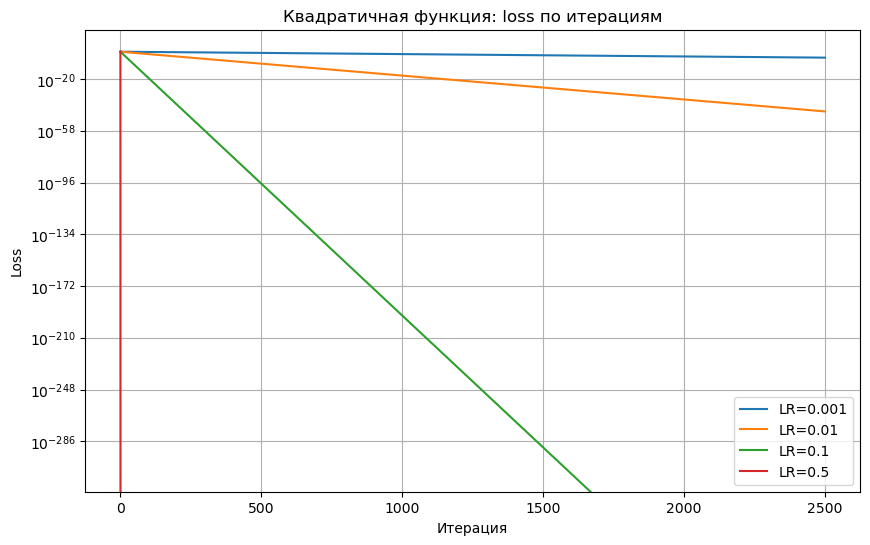

LR=0.01 пропущен — loss расходитcя
LR=0.1 пропущен — loss расходитcя
LR=0.5 пропущен — loss расходитcя


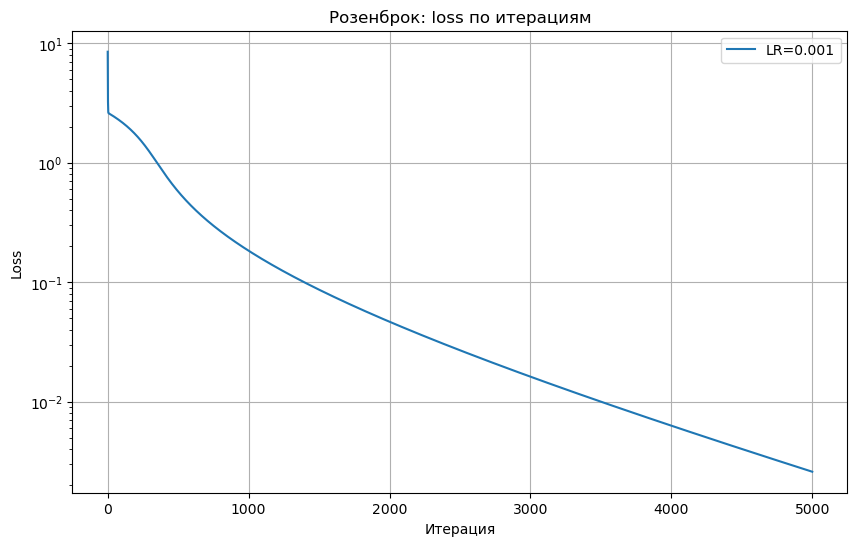

In [48]:
# ваш код здесь
#  график для квадратичной функции
plt.figure(figsize=(10,6))
for lr, losses in results_loss_quadr.items():
    plt.plot(losses, label=f"LR={lr}")
plt.title("Квадратичная функция: loss по итерациям")
plt.xlabel("Итерация")
plt.ylabel("Loss")
plt.yscale("log")
plt.legend()
plt.grid(True)
plt.show()

#график для Розенброка
plt.figure(figsize=(10,6))
for lr, losses in results_loss_rosen.items():
    losses_array = np.array(losses)
    if np.any(np.isnan(losses_array)) or np.any(np.isinf(losses_array)): #на nan все падало, поэтому добавила обработку таких значений
        print(f"LR={lr} пропущен — loss расходитcя")
        continue
    plt.plot(losses_array, label=f"LR={lr}")
plt.title("Розенброк: loss по итерациям")
plt.xlabel("Итерация")
plt.ylabel("Loss")
plt.yscale("log")
plt.legend()
plt.grid(True)
plt.show()


**Ваши выводы здесь.**

Выводы по квадратичной функции: 
- на всех learning rates лосс монотонно убывает = все корректно работает
- на 0.001 видно, что очень медленно снижается loss и все медленно работает - медленное схождение град спуска, для выбранного числа итераций так и не сошлось 
- на 0.01 быстрее чем 0.001, меньше итераций требуется на сходимость, но также не сошлось (на 2500 итераций)
- на 0.01 лосс падает значительно сильнее, все сходится где то примерно на 1600 итерации
- на 0.5 лосс стремительно падает вниз и сходится на первых же итерациях - топ! Можно было предположить, что это большой шаг, но в данном случае это хороший вариант, который приводит к стремитлеьной сходимости. 

Выводы по Розенброку: 
- как можно отметить, не разошелся у нас только шаг 0.001. На нем лосс умеренно уменьшается, медленно достаточно, тут итераций больше чем на квадратичной стоит и даже 5000 ему не хватило, но он был близок к финишу! Можно также отметить, что нет скачков резких, все идет плавно, кроме самого начала функции, когда был резкий упад и потом сильное замедление. Можно сделать вывод, что нам нужен небольшой шаг (0.001 или около того) и большое количество итераций (5000 и более)

### **Задание 4. Расписания для learning rate и победа над бананами (3 балла)**

В предыдущих заданиях мы рассматривали градиентный спуск с постоянным шагом обучения

$$w_{k+1} = w_k - \eta\nabla L(w_k),$$
где $\eta$ (learning rate) — фиксированная константа. Но графики функций выше вблизи минимумов наталкивают на ледующую интуицию (встречающуюся очень часто) —  в начале обучения продуктивнее делать большие шаги, чтобы быстро “спуститься” с вершины/плато, ближе к минимуму шаг нужно уменьшать, чтобы не перепрыгнуть минимум.

Чтобы реализовать эту идею, на практике почти всегда используют расписание для шага обучения (learning rate schedules): $\eta$ делают зависящим от номера итерации:

$$\eta_k = \eta(k), \quad k = 0, 1, 2, \dots$$

Даже в самых сложных модификациях градиентного спуска (Momentum, Adam, Adagrad, RMSProp и т.п.) всегда есть базовый learning rate ((\eta), (\alpha)) и “соседние” гиперпараметры, которые управляют эффективным шагом, так что идея “шаг со временем меняется” присутствует всегда, даже если она спрятана в более сложной формуле.

**Варианты расписаний:**

1. **Step decay (ступенчатое уменьшение):**
   $$
   \eta_k =
   \begin{cases}
   \eta_0, & k < k_1, \\
   \eta_0 \cdot \gamma, & k_1 \le k < k_2 \\
   \eta_0 \cdot \gamma^2, & k \ge k_2.
   \end{cases}
   $$

2. **Exponential decay:**
   
   $$\eta_k = \eta_0 \cdot \gamma^k, \quad 0 < \gamma < 1.$$

3. **Inverse time decay:**
   $$\eta_k = \frac{\eta_0}{1 + \lambda k}.$$

и на самом деле — безумно много других — cosine decay, warm restarts и т.п.. Вам не нужно их заучивать, но важно их знать, чтобы понимать, как улучшать свои решения. Поэтому давайте сделаем простое расписание своими руками.

#### **4.1 Реализация расписания (1.5 балла)**

1. **Модифицируйте класс `GradientDescent`** так, чтобы он поддерживал **расписание шага обучения — inverse time decay**.



In [51]:
class GradientDescentWithScheduler:
    """
    Градиентный спуск с опциональным расписанием learning rate.

    Параметры
    ---------
    learning_rate : float — базовый шаг обучения η_0.
    n_iterations : int — число итераций.
    decay : float или None
        если decay is None — шаг обучения постоянный: η_k = η_0.
        если decay > 0 — inverse time decay:
            η_k = η_0 / (1 + decay * k),
        где k — номер итерации (0, 1, 2, ...).

    Пример вызовы:
    -------
    # постоянный шаг
    gd_const = GradientDescentWithScheduler(learning_rate=0.01, n_iterations=1000)

    # убывающий шаг
    gd_decay = GradientDescentWithScheduler(learning_rate=0.01, n_iterations=1000, decay=0.001)
    """
    def __init__(self, learning_rate=0.01, n_iterations=1000, decay=None):
        self.learning_rate = float(learning_rate)
        self.n_iterations = int(n_iterations)
        self.decay = None if decay is None else float(decay) # ваш код здесь

        # сюда будем сохранять историю обучения
        self.history = {}

    def fit(self, loss_fn, grad_fn, initial_params):
        """
        Запустить градиентный спуск.

        Параметры
        ---------
        loss_fn : callable
            Функция потерь L(w): np.array -> float.
        grad_fn : callable
            Градиент ∇L(w): np.array - np.array той же размерности.
        initial_params : array-like
            Начальный вектор параметров w_0.

        Возвращает
        params : np.ndarray
            Финальные параметры после n_iterations.
        """
        params = np.array(initial_params, dtype=float)

        params_history = []
        loss_history = []
        lr_history = []

        for k in range(self.n_iterations):
            # шаг обучения на текущей итерации
            if self.decay is None:
                lr_k = self.learning_rate# ваш код здесь
            else:
                lr_k = self.learning_rate / (1 + self.decay * k)# ваш код здесь

            grad = np.array(grad_fn(params), dtype=float)# ваш код здесь
            params = params - lr_k * grad# ваш код здесь
            loss = loss_fn(params)# ваш код здесь

            params_history.append(params.copy())# ваш код здесь
            loss_history.append(loss)# ваш код здесь
            lr_history.append(lr_k)# ваш код здесь

        self.history = {
            "params": params_history,
            "loss": loss_history,
            "lr": lr_history
        }
        return params


#### **4.2 Победа над сложным минимумом (1.5 балла)**

1. **Сравните поведение градиентного спуска с постоянным lr и с расписанием lr** на функции Розенброка:

   * стартуйте из точки, фиксированной в коде с фиксрованным lr
   * запустите:

     * градиентный спуск с **постоянным** шагом $η = η_0$;
     * градиентный спуск с **убывающим** шагом $η_k$ (exponential decay или inverse time decay).

2. **Для каждого варианта:**

   * постройте 2D-контурный график функции Розенброка с траекторией;
   * постройте 3D-график ландшафта с траекторией;
   * постройте график значения loss по итерациям.

3. **Сделайте выводы. Опишите всё, что вы поняли о спуске из заданий.**

In [52]:
initial_point = np.array([0.3, 3])

# Подберите для этой точки оптимальный decay и lr, чтобы получить ошибку с расписанием < 0.05 (это реально)

lr = 0.001 #  ваш код здесь
decay = 0.0001 # ваш код здесь
# Постоянный learning rate
gd_const = GradientDescentWithScheduler(learning_rate=lr, n_iterations=20000) #
final_const = gd_const.fit(rosenbrock_loss, rosenbrock_grad, initial_point)

# Убывающий learning rate
gd_decay = GradientDescentWithScheduler(learning_rate=lr, n_iterations=20000, decay=decay) # ваш код здесь
final_decay = gd_decay.fit(rosenbrock_loss, rosenbrock_grad, initial_point)

print("Постоянный lr: ", final_const, rosenbrock_loss(final_const))
print("С расписанием: ", final_decay, rosenbrock_loss(final_decay))

Постоянный lr:  [1.00025399 1.00050906] 6.461392084172446e-08
С расписанием:  [1.00917061 1.01846181] 8.423320626565182e-05


можно отметить, что значения различаются, у lr  с раписаием показатели больше 

In [53]:
# Сетка для визуализации Розенброка
x_range = np.linspace(-2, 2, 300)
y_range = np.linspace(-1, 3, 300)
X, Y = np.meshgrid(x_range, y_range)
Z = (1 - X)**2 + 100 * (Y - X**2)**2

# Истории для наших двух вариантов GD
history_dict = {
    "Постоянный lr": gd_const.history,
    "Inverse time decay": gd_decay.history
}

# 2D-контуры + траектории
plot_gd_2d(
    x_range=x_range,
    y_range=y_range,
    Z=Z,
    history_dict=history_dict,
    title="Функция Розенброка: траектории GD (2D контуры)",
    start_points=[initial_point],
    min_point=(1.0, 1.0),
    contour_kwargs=dict(
        colorscale='Viridis',
        showscale=False,
        contours=dict(start=0, end=500, size=25),
        opacity=0.7
    )
)

# 3D-поверхность + траектории
plot_gd_3d(
    x_range=x_range,
    y_range=y_range,
    Z=Z,
    loss_fn=rosenbrock_loss,
    history_dict=history_dict,
    title="Функция Розенброка: траектории GD (3D ландшафт)",
    min_point=(1.0, 1.0)
)


чуть не забыла по лоссам тоже график!

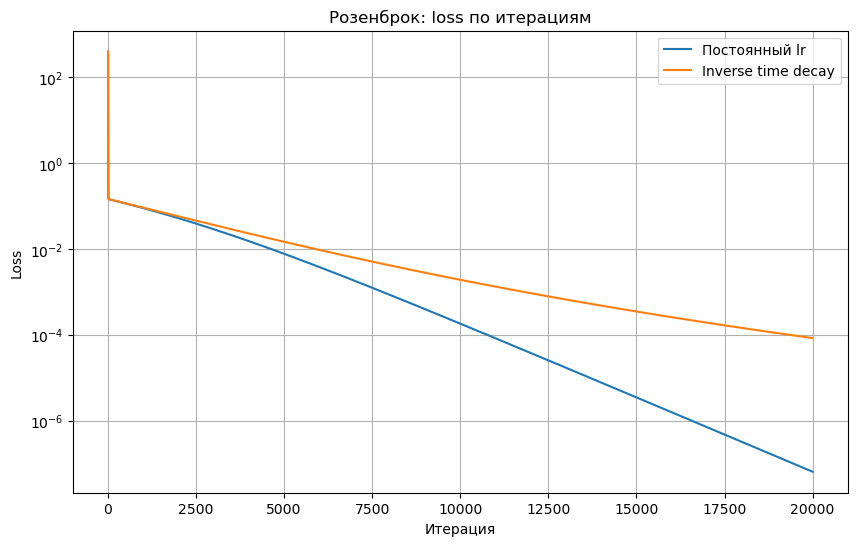

In [54]:
results = [
    ("Постоянный lr", gd_const.history['loss']),
    ("Inverse time decay", gd_decay.history['loss'])
]

plt.figure(figsize=(10,6))

for label, losses in results:
    losses_array = np.array(losses)
    if np.any(np.isnan(losses_array)) or np.any(np.isinf(losses_array)): #обработываю как в прошлый раз
        print(f"{label} пропущен — loss расходитcя")
        continue
    plt.plot(losses_array, label=label)

plt.title("Розенброк: loss по итерациям")
plt.xlabel("Итерация")
plt.ylabel("Loss")
plt.yscale("log")
plt.legend()
plt.grid(True)
plt.show()


**Общие выводы.**

- Мне кажется по визуализации, будто бы графики для lr обычного и lr с расписанием совпадают, они будто бы наложены друг на друга, можно предположить, что примерно равны они
- по визуализации видно, что построянный lr начиная с примерно 2500 итерации начинает быстрее сходиться, чем по инверсионный. Но они оба стремятся к схождению, достаточно медленно, на 20000 итерации так и не сошлись, но они близки к победе! 

## **Бонус 0.25 балла**

Проанализируйте график лосс-функции ниже. Попробуйте сформулировать гипотезы:
- Что происходит?
- Что с этим делать?

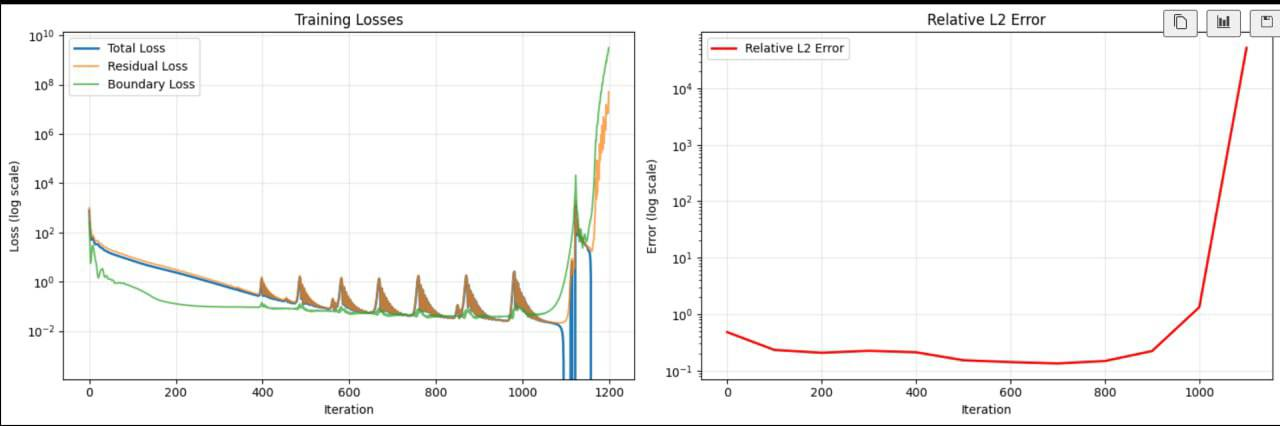

На левом графике общий лосс сначала быстро уменьшается, а потом идут скачки (вверх вниз) после достижения плато. 

Правый график в свою очередь отражает что до этапа со скачками у нас идет снижение ошибки, а потом по мере появления скачков она возрастает, тут видна связь двух графиков - можно сделать вывод, что у этой модели нестабильное обучение 

Скачки могут возникнуть из-за большого размера шага (примерно как было выше с 0.9, но тогда все было ок для квадратичной функции). Также видно, что тут разные слагаемые лосса, может, они представленны разным масштрабом друг от друга. 

В такой ситуации могу предложить только уменьшить learning rate и поглядеть как себя ведет функции на измененном параметре. И можно данные масштрабировать, если они реально сильно различаюстя. 